In [ ]:
from google.colab import drive
root = '/content/drive'
drive.mount(root)

Mounted at /content/drive


In [ ]:
!pip install -U bitsandbytes
!pip install -U evaluate rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
# ✅ Confirm install
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

from datasets import load_from_disk
from huggingface_hub import login
from sentence_transformers import SentenceTransformer
#import evaluate


import os

import pandas as pd
import re
from pprint import pprint

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import combinations_with_replacement
import numpy as np

from torch.nn.functional import cosine_similarity
import numpy as np

In [ ]:
recipe_nlg_data_path = f'{root}/MyDrive/NLP-266/Project/RecipeNLG'

### Evaluation Helpers

In [ ]:
def get_generated_instruction_list(batch):

  # find all "n."
  # split on "n."
  # Remove number from strings
  # Return list
  instructions = []
  instruction_starts = sorted([match.span() for match in re.finditer(r'\[\d+\]', batch['generated_clean'])])
  for i, span in enumerate(instruction_starts):
    if i == len(instruction_starts) - 1:
      instruction = batch['generated_clean'][span[-1]:]
    else:
      instruction = batch['generated_clean'][span[-1]:instruction_starts[i+1][0]]

    instructions.append(instruction.strip())

  return {"generated_instruction_list": instructions}

def get_reference_instruction_list(batch):
  return {
          "reference_instruction_list": [
              directions.split('", "')
              for directions in batch["directions"]
              ]
      }

def extract_new_tokens(example):
  return {"generated_clean": example['generated'].split("Your response:")[-1].strip()}

def get_generated_instruction_list(batch):
    generated_list = batch["generated_clean"]
    all_instructions = []

    for text in generated_list:
        # Find all "n." (e.g., "1.", "2.", etc.)
        instruction_starts = sorted([match.span() for match in re.finditer(r'\[\d+\]', text)])
        instructions = []

        for i, span in enumerate(instruction_starts):
            if i == len(instruction_starts) - 1:
                instruction = text[span[-1]:]
            else:
                instruction = text[span[-1]:instruction_starts[i+1][0]]
            instructions.append(instruction.strip())

        all_instructions.append(instructions)

    return {"generated_instruction_list": all_instructions}


def get_generated_assignments(example):

    ref = example['reference_instruction_list']
    gen = example['generated_instruction_list']

    if not gen:
        return {"generated_assignments": None}

    ref_embed = model.encode(ref, convert_to_tensor=True).cpu()
    gen_embed = model.encode(gen, convert_to_tensor=True).cpu()

    sims = np.array(
        [
            [cosine_similarity(g, r, dim=0) for r in ref_embed]
            for g in gen_embed
        ]
    ) #g by r matrix

    generated_assignments = np.argmax(sims, axis=1)

    return {"generated_assignments": generated_assignments}

def instruction_similarity(example):

    generated_assignments = example['generated_assignments']

    if generated_assignments is None:
      return {"spearman_correlation": 0.0}
    g_indices = np.arange(len(generated_assignments))

    corr, _ = spearmanr(g_indices, generated_assignments)

    return {"spearman_correlation": corr if not np.isnan(corr) else 0.0}

def get_data_similarity_score(references, generated):
    scores = [instruction_similarity(r, g) for r, g in zip(references, generated)]
    return np.mean(scores)

def get_data_similarity_score_display(references, generated):
    pairs = zip(references, generated)
    scores = []
    for i, pair in enumerate(pairs):
        if i % 10 == 0:
          print(f"Pair {i}:")
        score = instruction_similarity(pair[0], pair[1])
        scores.append(score)
    return np.mean(scores)

### Setup Sentence Transformer Model

In [ ]:
model_id = 'multi-qa-MiniLM-L6-cos-v1'

# Load a model (change to a newer one if you like)
model = SentenceTransformer(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
d = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_two_shot').map(extract_new_tokens)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
refs = d['directions']
gens = d['generated_clean']

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
scores = [scorer.score(ref, gen) for ref, gen in zip(refs, gens)]

print(f"Mean: {np.mean([score['rougeL'].fmeasure for score in scores])}")
print(f"Max: {max([score['rougeL'].fmeasure for score in scores])}")
print(f"Min: {min([score['rougeL'].fmeasure for score in scores])}")
print(f"Std: {np.std([score['rougeL'].fmeasure for score in scores])}")

Mean: 0.3106353592792624
Max: 0.6744186046511628
Min: 0.0
Std: 0.0954238107352868


In [ ]:
np.quantile([s['rougeL'].fmeasure for s in scores], 0.2)

np.float64(0.2297872340425532)

### MISC Functions

In [ ]:
def get_data_similarity_score_dataset(dataset, clean=False):

  dataset = dataset.map(extract_new_tokens, batched=False)

  dataset = dataset.map(get_reference_instruction_list, batched=True, batch_size=32)
  dataset = dataset.map(get_generated_instruction_list, batched=True, batch_size=32)

  dataset = dataset.map(get_generated_assignments, batched=False)

  """
  if clean:
    g_r = [[gen, ref] for gen, ref in zip(gens, refs) if len(gen) > 0]
    print(f"Percent Response: {100 * len(g_r) / len(gens):.2f}%")
    gens = [gr[0] for gr in g_r]
    refs = [gr[1] for gr in g_r]
  """

  dataset = dataset.map(instruction_similarity, batched=False)

  return dataset

### Hyperparameter Tests

In [ ]:
#teacher_fine_tuned = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_1l')

l1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_1l')
l2 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_2l')
l4 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_4l')
l8 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_8l')
l12 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_12l')
l16 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_16l')

In [ ]:
k1 = l1
k2 = load_from_disk(f'file://{recipe_nlg_data_path}/ft_generated_2k')
k5 = load_from_disk(f'file://{recipe_nlg_data_path}/ft_generated_5k')
k10 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_10k_test_2e_4l')

e2 = k1
e5 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_5e_4l')

In [ ]:
layer_tests = [('1', l1), ('2', l2), ('4', l4), ('8', l8), ('12', l12), ('16', l16)]

In [ ]:
scores = []
for n_layers, df in layer_tests:
  df = get_data_similarity_score_dataset(df, clean=True)
  df = df.to_pandas()
  good = df[df['spearman_correlation'] != 0]
  bad = df[df['spearman_correlation'] == 0]
  score = good['spearman_correlation'].mean()
  scores.append(score)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/tmp/ipython-input-1190351358.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
e_scores = []

epoch_tests = [(2, e2), (5, e5)]
#for epochs, df in epoch_tests:
df = e5
df = get_data_similarity_score_dataset(df, clean=True)
df = df.to_pandas()
good = df[df['spearman_correlation'] != 0]
bad = df[df['spearman_correlation'] == 0]
score = good['spearman_correlation'].mean()
#e_scores.append(score)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
bad['generated'].iloc[0]

'You are an expert in generating recipe instructions from the recipe title and ingredient list.\nWrite recipe instructions for the following recipe title and ingredient list.\nEach step should be numbered, and the number should precede the step text and be enclosed in square brackets (like [1] or [13]).\nRecipe Title: Hot link potato soup\nIngredients: ["5 medium potatoes cut in chunks (peeled if you prefer)", "32 oz chicken stock", "1 tsp garlic powder", "1 tsp Italian seasoning", "1 tsp black pepper", "1 tbsp dried chopped onion", "2 1/2 cup milk", "2 cup grated sharp cheddar cheese", "1 cup apple smoked gruyere cheese grated", "5 Louisiana hot links halved then cut in small chunks", "1 6.5 ounce minced clams (liquid included)", "2 cup corn", "1 salt\\\\pepper to taste", "1 sour cream"]\nYour response: in until") of top.", " (" 0.50" over over 7000 of halfed a and 0. in hal ingredients in or in or with with.",0". minutes minutes or top minutes and and top minutes and stir until minut

In [ ]:
e_scores

[np.float64(0.4912878062951702), nan]

In [ ]:
k_scores = []

train_size_tests = [(1, k1), (2, k2), (5, k5), (10, k10)]
for k, df in train_size_tests:
  df = get_data_similarity_score_dataset(df, clean=True)
  df = df.to_pandas()

  good = df[df['spearman_correlation'] != 0]
  print(k, f"Good/1000: {good.index.size}")
  score = good['spearman_correlation'].mean()
  k_scores.append(score)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/tmp/ipython-input-1190351358.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(g_indices, generated_assignments)


1 Good/1000: 980


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

2 Good/1000: 104


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

5 Good/1000: 0


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

10 Good/1000: 0


In [ ]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 5, 10], k_scores[:2] + [0]*2, marker='o', c='orange')
plt.suptitle('Spearman Correlation by Number of Training Examples')
plt.title('4-layer Fine-Tune', fontdict={'fontsize':11})
plt.xlabel('Number of Training Examples (in K)')
plt.ylabel('Spearman Correlation')
plt.xticks([1, 2, 5, 10])

NameError: name 'k_scores' is not defined

([<matplotlib.axis.XTick at 0x7b9d35324c50>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(12, 0, '12'),
  Text(16, 0, '16')])

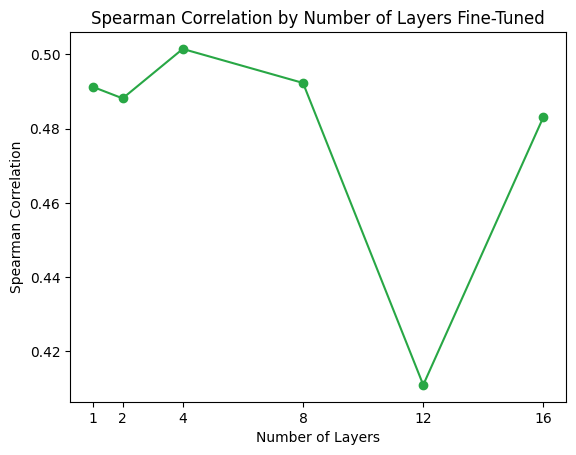

In [ ]:

xs = [1, 2, 4, 8, 12, 16]
plt.plot(xs, scores, marker='o', color='blue')
plt.title('Spearman Correlation by Number of Layers Fine-Tuned')
plt.xlabel('Number of Layers')
plt.ylabel('Spearman Correlation')
plt.xticks(xs)

### Metric Contradiction Examples

In [ ]:
spearmanr(np.arange(len(ex['generated_assignments']) - 1), [0, 1, 2, 2, 1, 3, 3, 3])

SignificanceResult(statistic=np.float64(0.8647908694379515), pvalue=np.float64(0.0055698626658775285))

In [ ]:
ref = """Preheat the oven to 375°F.

Mix flour, sugar, and eggs in a bowl.

Pour the batter into a greased pan.

Bake for 25 minutes."""

gen = """Set your oven to 375 degrees Fahrenheit.

Combine eggs, sweetener, and flour inside mixer.

Transfer mixture to buttered baking dish.

Cook twenty-five minutes in the oven."""

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
scores = scorer.score(ref,
                      gen)
scores

{'rouge1': Score(precision=0.37037037037037035, recall=0.4, fmeasure=0.3846153846153846),
 'rougeL': Score(precision=0.2222222222222222, recall=0.24, fmeasure=0.23076923076923075)}

## LLM Judge Generations

In [ ]:
list_delim = '", "'

def form_direction_step_text(direction_list_str):
  # parse out parentheses
  direction_str = direction_list_str[1:-1]

  # split string
  str_list = direction_str.split(list_delim)

  # remove leading and trailing quotes
  str_list[0] = str_list[0][1:]
  str_list[-1] = str_list[-1][:-1]


  # number with consistent formatting [1], [2], ...
  s_list_num = [f'[{i+1}] {s}' for i, s in enumerate(str_list)]
  final_str = '\n'.join(s_list_num)

  return final_str

## Non-CoT

In [ ]:
# Non-Fine-Tuned
## Non-Retrieval
nft_nr_0 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])}) # baseline
nft_nr_1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_one_shot_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_nr_2 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_two_shot_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_nr_3 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_three_shot_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

## Retrieval
nft_r_1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_one_shot_retrieval_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_r_2 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_two_shot_retrieval_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
nft_r_3 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_three_shot_retrieval_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

# Fine-Tuned
## Non-Retrieval
ft_nr_0 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/qlora_1k_test_2e_4l').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_nr_1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_one_shot').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_nr_2 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_two_shot').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_nr_3 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_three_shot').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

# Retrieval
ft_r_1 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_one_shot_ret').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_r_2 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_two_shot_ret').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
ft_r_3 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/ft_three_shot_ret').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### CoT

In [ ]:
cot_nft_7 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/oob_cot_generated').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
cot_ft_7 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/7b_instruction_model_from_teacher_generated_instructions').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

cot_nft_13 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/13b_cot_non_ft_instruction_generation').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
cot_ft_13 = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/13b_instruction_model_from_teacher_generated_instructions').map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

In [ ]:
cot_model_dict_better = {
    'nft': {
        'retrieval':
            ['1', '2', '3']
        ,
        'non-retrieval':
            ['1', '2', '3']
    }
}

In [ ]:
load_from_disk

In [ ]:
for ft, val1 in cot_model_dict_better.items():
  for ret, val2 in val1.items():
    for shots in val2:
      file_ext = f'{recipe_nlg_data_path}/Generated_Data/' \
                 f'cot_{ft}_shots_{shots}_retrieval_{"True" if ret == "retrieval" else "False"}'
      if os.path.exists(file_ext):
        n = load_from_disk(file_ext).map(
    lambda x: {'directions_formatted': form_direction_step_text(x['directions'])}).map(
        extract_new_tokens, batched=False)
        n = n.map(lambda x: {'title_ingredients': form_example_prompt(x)})
        n = n.map(lambda x: {'comparison_prompt': form_comparison_prompt(x['title_ingredients'], x['directions_formatted'], x['generated_clean'])})
        n = n.map(lambda x: {'reference_free_prompt': form_reference_free_prompt(x['title_ingredients'], x['generated_clean'])})
        n = n.map(lambda x: generate_evaluation_batch(
      x, prompt_col='comparison_prompt', model=eval_model, tokenizer=tokenizer),
            batched=True,
            batch_size=16)
        n.save_to_disk(f'file://{file_ext}_eval')


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chinatown Sling
  Ingredients: ["16 ounces pineapple juice", "10 ounces gin", "4 ounces tr

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Pasta with Arugula and Caramelized Onions
  Ingredients: ["1/2 lb. hot Italian sausage, ca

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Vegetable Pasta Sauce (Lactose Free)
  Ingredients: ["1 packages Melissas Extra Firm Tofu"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Fluffy Double-Raspberry Pie
  Ingredients: ["4 pkg. JELL-O Vanilla Flavor Sugar Free Reduc

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cinnamon Grapefruit Sorbet Recipe
  Ingredients: ["2 1/2 Cups Ruby Red Grapefruit Juice", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Lumpia (Filipino Egg Rolls) 
  Ingredients: ["2 tbsp vegetable oil", "1 lb lean ground por

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: topsy turvy sangria
  Ingredients: ["1 bottle merlot", "1 cup sugar", "1 cup orange liqueu

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Three-Cheese Bacon and Kale Dip
  Ingredients: ["4 cups tightly packed chopped stemmed kal

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Savory Squash & Bean Side Dish
  Ingredients: ["6 slices OSCAR MAYER Bacon, chopped Rite A

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Aromatic Fish Soup Recipe
  Ingredients: ["1/2 tsp chilli flakes", "1 tsp cumin", "2 tsp p

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cheesy Sweet Potato Balls
  Ingredients: ["1/2 cup mashed cooked sweet potato", "1 cup coo

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Buttermilk Prairie Waffles
  Ingredients: ["2 cups sifted flour", "1 teaspoon baking powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Shrimp And Pasta Casserole 
  Ingredients: ["1 lb. elbow macaroni", "6 strips bacon, diced

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Fish With Shrimp
  Ingredients: ["3 tablespoons butter", "2 tablespoons all-purpose 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Peaches 'n Creme Pie
  Ingredients: ["48 Nilla Vanilla Wafers, finely crushed (about 1-1/2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Southwest Cornbread Stuffing
  Ingredients: ["2 cups chopped onions King Sooper's 1 lb For

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: The Parasol
  Ingredients: ["1/2 ounce fresh lemon juice", "1/2 ounce fresh lime juice", "

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Savory Beef Roast
  Ingredients: ["1 (4-pound) lean boneless rump roast", "Cooking spray",

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Italian Barbecue Chicken Recipe
  Ingredients: ["4 x chicken breasts", "2 tsp Italia

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sombrero Pasta Salad
  Ingredients: ["1 package (16 ounces) spiral pasta", "1 pound ground

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Eggplant Pizzas
  Ingredients: ["1 cup all-purpose flour", "4 large eggs, beaten", "2-1/2 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cilantro Pesto
  Ingredients: ["1/2 cups (heaping) Blanched, Slivered Almonds", "1 clove F

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Pretzel Pecan Coated Chicken Tenders
  Ingredients: ["2 pounds chicken tenders", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Homemade Cajun Tasso
  Ingredients: ["2 lb thinly sliced scrap pork pieces, trimmed of exc

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Corn-Crusted Catfish
  Ingredients: ["10 ounces catfish fillet", "1/2 cup buttermilk", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Buttermilk Prairie Waffles
  Ingredients: ["2 cups sifted flour", "1 teaspoon baking powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Southwest Cornbread Stuffing
  Ingredients: ["2 cups chopped onions King Sooper's 1 lb For

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Red Chile Sauce
  Ingredients: ["2 tablespoons lard", "2 tablespoons flour, all-purpose", 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cilantro Pesto
  Ingredients: ["1/2 cups (heaping) Blanched, Slivered Almonds", "1 clove F

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Wild Orchid Martini
  Ingredients: ["1 ounce vanilla vodka", "1/2 ounce vodka", "1/2 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mary Mac's Buttermilk Biscuits Recipe
  Ingredients: ["2 c. plus 2 tbsp. all purpose flour

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Quick Chicken with Garlic, Tarragon, and Red Wine
  Ingredients: ["2 tablespoons olive oil

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Classic Sandwich Bread for the Bread Machine
  Ingredients: ["9 oz. milk warmed", "4 tbsp.

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Wedge Salad with Raspberry-Chocolate Vinaigrette
  Ingredients: ["4 slices sourdough bread

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: The “Original” Margarita
  Ingredients: ["FOR RIMMING THE GLASS:", "1 whole Lime, Cut Into

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mom's Apple Cobbler with Buttermilk Biscuit Topping Recipe
  Ingredients: ["4 tablespoons 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Golden Sponge Cake with Creamy Filling
  Ingredients: ["1 box yellow cake mix", "5 tablesp

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Whoopie Cookies
  Ingredients: ["1 package devil's food cake mix (regular size)", "1/4 cup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Wild Orchid Martini
  Ingredients: ["1 ounce vanilla vodka", "1/2 ounce vodka", "1/2 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chocolate, Nut And Cornflake Bars
  Ingredients: ["1/2 cup butter, coarsely chopped", "1/2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Buttermilk Prairie Waffles
  Ingredients: ["2 cups sifted flour", "1 teaspoon baking powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Red Chile Sauce
  Ingredients: ["2 tablespoons lard", "2 tablespoons flour, all-purpose", 

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
cot_model_dict = {
    "Non-Fine-Tuned": {
        "7b": cot_nft_7,
        "13b": cot_nft_13
    },
    "Fine-Tuned": {
        "7b": cot_ft_7,
        "13b": cot_ft_13
    }
}

In [ ]:
model_dict = {
    "Non-Fine-Tuned": {
        "Non-Retrieval": {
            "0": nft_nr_0,
            "1": nft_nr_1,
            "2": nft_nr_2,
            "3": nft_nr_3
        },
        "Retrieval": {
            "1": nft_r_1,
            "2": nft_r_2,
            "3": nft_r_3
        }
    },
    "Fine-Tuned": {
        "Non-Retrieval": {
            "0": ft_nr_0,
            "1": ft_nr_1,
            "2": ft_nr_2,
            "3": ft_nr_3
        },
        "Retrieval": {
            "1": ft_r_1,
            "2": ft_r_2,
            "3": ft_r_3
        }
    }
}

In [ ]:
generated_col = 'generated'
reference_col = 'directions_formatted'

### LLM-as-a-Judge Prompting

In [ ]:
# could compare to reference quality or just evaluate on its own

def form_comparison_prompt(original_recipe_prompt, reference, generated):
  comparison_prompt = f"""<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  {original_recipe_prompt}

  ---

  **Reference Instructions:**
  {reference}

  ---

  **Model's' Instructions:**
  {generated}

  ---

  **Your Evaluation:**
[1] Coherence Rating for Reference (1–10):
[2] Coherence Rating for Model (1–10):
[3] Which is better and why (2–5 sentences):

Prepend your answer to the items in these last 3 lines with [1], [2], and [3] respectively.<|im_end|>
<|im_start|>assistant
  """.strip()

  return comparison_prompt

def form_reference_free_prompt(original_recipe_prompt, generated):
  reference_free_prompt = f"""<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 10 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  {original_recipe_prompt}

  ---

  **Model's' Instructions:**
  {generated}

  ---

  **Your Evaluation:**
[1] Coherence Rating (1–10):
[2] Explanation (2–5 sentences):

Prepend your answer to the items in these last 2 lines with [1] and [2] respectively.<|im_end|>
<|im_start|>assistant
  """.strip()

  return reference_free_prompt

def form_example_prompt(example):
  return f'''
  Title: {example['title']}
  Ingredients: {example['ingredients']}
  '''.strip()



PROMPT_HPS = {
    'do_sample': False,                # Disable sampling for determinism
    'temperature': 0.0,                # Eliminate randomness
    'top_p': 1.0,                      # Not used if do_sample=False, but safe
    'max_new_tokens': 256,            # Should be enough for rating + explanation
    'stop_sequences': None,           # Optional: use if you want clean terminations
    'repetition_penalty': 1.0,        # No need for penalty in judgment tasks
    'use_cache': True                 # Leave as is for performance
}

def generate_evaluation_batch(batch, prompt_col=None, model=None, tokenizer=None):

    print(batch[prompt_col][0])

    inputs = tokenizer(
        batch[prompt_col],
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)

    hps = PROMPT_HPS.copy()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **hps,
            pad_token_id=tokenizer.pad_token_id,
            max_length=model.config.max_position_embeddings
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return {f'eval_response_{prompt_col}': decoded}

### Setup Judge Model

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True
)

In [ ]:
### Load Qwen 32B model

model_id = "Qwen/Qwen2.5-Coder-32B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

eval_model = AutoModelForCausalLM.from_pretrained(
  model_id,
  return_dict=True,
  torch_dtype=torch.float16,
  device_map="auto",
  quantization_config=quantization_config
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

### CoT LLM Judge Eval

In [ ]:
for key1, val1 in cot_model_dict.items():
  for key2, n in val1.items():
    file_ext = f'{recipe_nlg_data_path}/Generated_Data/Evaluations/CoT_{key1}_{key2}'
    print(file_ext)
    if os.path.exists(file_ext):
      print("Skipping")
      continue
    n = n.map(lambda x: {'title_ingredients': form_example_prompt(x)})
    n = n.map(lambda x: {'comparison_prompt': form_comparison_prompt(x['title_ingredients'], x['directions_formatted'], x['generated'])})
    n = n.map(lambda x: {'reference_free_prompt': form_reference_free_prompt(x['title_ingredients'], x['generated'])})
    n = n.map(lambda x: generate_evaluation_batch(
  x, prompt_col='comparison_prompt', model=eval_model, tokenizer=tokenizer),
        batched=True,
        batch_size=16)
    n.save_to_disk(f'file://{file_ext}_incomplete')
    """
    n = n.map(lambda x: generate_evaluation_batch(
  x, prompt_col='reference_free_prompt', model=eval_model, tokenizer=tokenizer),
        batched=True,
        batch_size=16)
    n.save_to_disk(f'file://{file_ext}')
    """



/content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/Evaluations/CoT_Non-Fine-Tuned_7b


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Acorn Squash Stuffed With Greens And White Beans 
  Ingredients: ["2 medium acorn squash, 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Irish Apple Beer Bread
  Ingredients: ["1/2 cups Softened Butter", "1 cup Sugar", "2 whole

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Salsa Verde
  Ingredients: ["3 tomatillo", "1 Serrano pepper", "1 cup yellow onion, choppe

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Bolo De Fuba Cremoso (Creamy Cornmeal Cake)
  Ingredients: ["4 cups milk", "2 cups white s

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Strawberry Shortcake Soup
  Ingredients: ["1 quart fresh strawberries, hulled and quartere

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Slow-Cooker Baked Spinach And Mushroom Rigatoni From Real Simple
  Ingredients: ["28 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Street Food Alert: Indian Grilled Corn
  Ingredients: ["4 ears of corn", "1 cup ghee (or m

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Open-Faced Bacon and Cucumber-Salad Sandwiches
  Ingredients: ["1/2 cup plain yogurt", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Butterscotch Spice Cake
  Ingredients: ["1 (18.25 ounce) package spice cake mix", "1 (3.4 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Brown Sugar Oatmeal Pancakes
  Ingredients: ["1/2 cup plus 2 tablespoons quick-cooking oat

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mini Calzone Recipe
  Ingredients: ["1/2 pound Ricotta cheese", "1 egg", "1/4 c. grated Ro

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Creamy Latte Pops
  Ingredients: ["1 (14 oz.) can Eagle Brand(R) Sweetened Condensed Milk"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Squash Soup 
  Ingredients: ["1 med butternut squash", "2 tbsp vegetable oil", "3-4 tbsp c

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chocolate Chip Cream Cheese Delights Recipe
  Ingredients: ["2 Large eggs", "1/2 c. sugar"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Colorful Chicken Pesto With Asparagus, Sun Dried Tomatoes And Peppers
  Ingredients: ["10 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: One-Pot Primavera Pasta
  Ingredients: ["2 cups bite-sized pasta, uncooked", "1 tomato, ch

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Savory Pork Salad
  Ingredients: ["1 garlic clove, minced", "1/2 teaspoon minced fresh gin

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Creamy Salmon Baked Omelet Brunch
  Ingredients: ["1 can (5 oz.) salmon, drained, flaked",

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: No Sugar Apple Pie
  Ingredients: ["3 tablespoons cornstarch", "1 tablespoon ground cinnam

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Easy Sweet And Sour Meatballs
  Ingredients: ["3/4 cup white vinegar", "3 tablespoons corn

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Somen Noodles with Wakame Soup
  Ingredients: ["1 bundle Somen noodles", "15 grams Wakame 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Roasted Hot Italian Sausages with Peppers and Onions
  Ingredients: ["2 red bell peppers, 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Egg Omelet Recipe
  Ingredients: ["3 Large eggs, beaten", "1/4 c. minced onions", "1 tbsp.

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Inside Out Ravioli
  Ingredients: ["1 package spinach chopped", "1 tablespoon vegetable oi

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Abm Foolproof Maple Oat Bread Recipe
  Ingredients: ["1/2 Tbsp. Yeast", "11/2 c. Oats", "3

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Red Velvet Hot Chocolate
  Ingredients: ["FOR THE HOT CHOCOLATE:", "3 Tablespoons Cocoa Po

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cream Cheese Pound Cake
  Ingredients: ["3 sticks margarine (softened)", "1 8 oz (224 grm)

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Three-Grain Pilaf
  Ingredients: ["2 tablespoons unsalted butter", "1 small onion, finely 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chicken Skillet With Sweet Potatoes & Wild Rice
  Ingredients: ["1 tablespoon olive oil", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chocolate Chip Buttermilk Scones
  Ingredients: ["3 cups self-rising flour", "2/3 cup suga

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Easy Homemade Vegetable Beef Soup Recipe
  Ingredients: ["1 pound stew meat", "2 (16 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Bibs Soles' Haroset Recipe
  Ingredients: ["2 x Apples, Spy", "1 Tbsp. Lemon juice, option

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Monkey Chow
  Ingredients: ["1 cup semisweet chocolate chips", "2/3 cup peanut butter", "8

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Christmas Wassail
  Ingredients: ["3 medium McIntosh or Rome apples, halved and cored", "1

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Swordfish Souvlaki
  Ingredients: ["1 pound skinless swordfish steak (about 1 inch thick),

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Brownie Pie A La Mode Recipe
  Ingredients: ["1/2 c. Sugar", "2 Tbsp. Butter or possibly m

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Hotel Cocktail Bars Make Their Big, Expertly Shaken, Comeback
  Ingredients: ["1 1/2 ounce

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cauliflower With Garlic, Chili And Anchovies
  Ingredients: ["4 1/3 pounds cauliflower cut

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Spinach , Artichoke And Roasted Red Pepper Dip
  Ingredients: ["1 can of atichoke quarters

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Corn and Radish Salad
  Ingredients: ["Coarse salt", "4 ears corn", "6 radishes, trimmed, 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Layered Marshmallow and Chocolate Pudding Pie
  Ingredients: ["2 pkg. (4-serving size each

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Rich Chocolate Rum Cookies
  Ingredients: ["1 1/4 cups all-purpose flour", "1 1/2 teaspoon

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Lemon Pavlova
  Ingredients: ["3 None egg whites", "3/4 cup granulated sugar", "1 1/4 cups

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Greek Style Potatoes
  Ingredients: ["1 can potatoes whole", "garlic powder", "paprika", "

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Honey-Coriander Glazed Ham
  Ingredients: ["1 1/2 tablespoons coriander seeds", "1 1/2 tea

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Tic Tac Toe Tartine With Red Radishes
  Ingredients: ["1 slice whole wheat bread, crusts r

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Pilaf for a Curry Banquet
  Ingredients: ["2 tablespoons vegetable oil", "1 large onion, f

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sloppy Shmoes
  Ingredients: ["1 teaspoon coriander seeds", "1 medium onion, chopped", "1 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Guacamole
  Ingredients: ["2 tablespoons finely chopped cilantro leaves, divided", "2 teas

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Strawberry Mochi
  Ingredients: ["prune Paste 170g", "2 1/2 ounces glutinous rice flour", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Candi's Caramel Popcorn
  Ingredients: ["1 cup Favourite nuts ( cashews, peanuts, or pecan

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Frozen Caramel Pie
  Ingredients: ["2 Graham Cracker Pie Crusts", "8 oz (224 grm). pkg. Cr

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Aloo Sfenaj
  Ingredients: ["2 pounds spinach", "1 large onion, coarsely chopped", "23 tab

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Honey Gingered Carrots & Leeks
  Ingredients: ["3 cups baby carrots", "Water", "2 tablespo

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Delicious Nikudofu (Simmered Meat and Tofu)
  Ingredients: ["200 grams Thinly sliced beef 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Potato Skins
  Ingredients: ["4 large russet potatoes baked", "3 tablespoons vegetab

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Brownie Kiss Cupcakes
  Ingredients: ["1/3 cup butter, softened", "1 cup sugar", "2 eggs",

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Creamy Zucchini Parmesan Soup
  Ingredients: ["1/4 cup extra virgin olive oil, plus extra 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mexican Beef (Crockpot)
  Ingredients: ["1 1/2-2 pound beef, round steak boneless", "1 eac

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Apache Dip Recipe
  Ingredients: ["1 x 9\" Apache loaf", "1 x (16 ounce.) pkg. sharp chedd

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Zucchini Fritters
  Ingredients: ["1 whole Medium Zucchini, Unpeeled And Grated", "1 cup F

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sweet And Sour Chicken
  Ingredients: ["3 chicken breasts", "salt to taste", "ground black

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Tepache (Slightly Fermented Pineapple Drink)
  Ingredients: ["4 very ripe whole pineapples

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Acorn Squash Stuffed With Greens And White Beans 
  Ingredients: ["2 medium acorn squash, halved and seeded", "1/2 cup chopped onion", "2 cloves garlic, chopp

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Irish Apple Beer Bread
  Ingredients: ["1/2 cups Softened Butter", "1 cup Sugar", "2 whole Eggs", "2 cups Apple Butter", "12 ounces, fluid Dark Beer, Stout Or

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Salsa Verde
  Ingredients: ["3 tomatillo", "1 Serrano pepper", "1 cup yellow onion, chopped", "1 tbsp garlic, minced", "1/2 cup green bell pepper, chopped", "

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Bolo De Fuba Cremoso (Creamy Cornmeal Cake)
  Ingredients: ["4 cups milk", "2 cups white sugar", "3 eggs", "3/4 cup grated Parmesan cheese", "2 1/2 tablespoon

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Strawberry Shortcake Soup
  Ingredients: ["1 quart fresh strawberries, hulled and quartered", "1/4 cup granulated sugar", "2 teaspoons fresh lemon juice (from

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Slow-Cooker Baked Spinach And Mushroom Rigatoni From Real Simple
  Ingredients: ["28 ounces whole peeled tomatoes", "2 tablespoons olive oil", "2 cloves garli

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Street Food Alert: Indian Grilled Corn
  Ingredients: ["4 ears of corn", "1 cup ghee (or make your own)", "1 tablespoon garam masala", "1 lime, zested", "1 ta

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Open-Faced Bacon and Cucumber-Salad Sandwiches
  Ingredients: ["1/2 cup plain yogurt", "2 large slices country-style bread", "1/2 English cucumber", "1/2 teas

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Butterscotch Spice Cake
  Ingredients: ["1 (18.25 ounce) package spice cake mix", "1 (3.4 ounce) package instant butterscotch pudding mix", "4 eggs", "1 cup w

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Brown Sugar Oatmeal Pancakes
  Ingredients: ["1/2 cup plus 2 tablespoons quick-cooking oats", "1/2 cup whole wheat flour", "1/2 cup all-purpose flour", "1/2 t

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Mini Calzone Recipe
  Ingredients: ["1/2 pound Ricotta cheese", "1 egg", "1/4 c. grated Romano cheese", "Sm. bits of ham", "1 pkg. Pillsbury pastry pockets"]


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Creamy Latte Pops
  Ingredients: ["1 (14 oz.) can Eagle Brand(R) Sweetened Condensed Milk", "2 cups milk", "1 cup heavy cream", "1 tablespoon plus 1 teaspoons

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Squash Soup 
  Ingredients: ["1 med butternut squash", "2 tbsp vegetable oil", "3-4 tbsp chopped ginger", "2-3 large garlic cloves", "1 med yellow onion (chop

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Chocolate Chip Cream Cheese Delights Recipe
  Ingredients: ["2 Large eggs", "1/2 c. sugar", "1 teaspoon vanilla", "2 (8 ounce.) Packages cream cheese", "2 Pac

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Colorful Chicken Pesto With Asparagus, Sun Dried Tomatoes And Peppers
  Ingredients: ["10 ounces uncooked angel hair pasta", "2 teaspoons olive oil", "2 skinl

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: One-Pot Primavera Pasta
  Ingredients: ["2 cups bite-sized pasta, uncooked", "1 tomato, chopped King Sooper's 1 lb For $0.99 thru 02/09", "1 green pepper, cut

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Savory Pork Salad
  Ingredients: ["1 garlic clove, minced", "1/2 teaspoon minced fresh gingerroot", "2 teaspoons olive oil", "1/2 pound pork tenderloin, thinl

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Creamy Salmon Baked Omelet Brunch
  Ingredients: ["1 can (5 oz.) salmon, drained, flaked", "1 cup each chopped green onions and red peppers", "1 tub (8 oz.) P

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: No Sugar Apple Pie
  Ingredients: ["3 tablespoons cornstarch", "1 tablespoon ground cinnamon", "12 ounces unsweetened apple juice concentrate", "6 cups thinly

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Easy Sweet And Sour Meatballs
  Ingredients: ["3/4 cup white vinegar", "3 tablespoons cornstarch", "12 ounces Smucker's Pineapple Preserves", "1/3 cup ketchup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Somen Noodles with Wakame Soup
  Ingredients: ["1 bundle Somen noodles", "15 grams Wakame seaweed (salted)", "15 cm Japanese leek", "1 tsp Sesame oil", "2 tsp

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Roasted Hot Italian Sausages with Peppers and Onions
  Ingredients: ["2 red bell peppers, seeded and cut into 1/2-inch strips", "2 medium onions, cut into 1/2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Egg Omelet Recipe
  Ingredients: ["3 Large eggs, beaten", "1/4 c. minced onions", "1 tbsp. butter", "1/4 c. minced peppers", "1/4 c. diced ham or possibly bac

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Inside Out Ravioli
  Ingredients: ["1 package spinach chopped", "1 tablespoon vegetable oil", "1 pound ground beef", "1 medium onions chopped", "1 clove garli

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Abm Foolproof Maple Oat Bread Recipe
  Ingredients: ["1/2 Tbsp. Yeast", "11/2 c. Oats", "3 c. Flour, bread", "1/2 Tbsp. Salt", "1/2 Tbsp. Dough enhancer, opti

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Red Velvet Hot Chocolate
  Ingredients: ["FOR THE HOT CHOCOLATE:", "3 Tablespoons Cocoa Powder", "2 cups Milk", "1 Tablespoon Vanilla Extract", "2 Tablespoons

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Cream Cheese Pound Cake
  Ingredients: ["3 sticks margarine (softened)", "1 8 oz (224 grm). package cream cheese(softened)", "3 cups (700 ml) sugar", "3 cups 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Three-Grain Pilaf
  Ingredients: ["2 tablespoons unsalted butter", "1 small onion, finely chopped", "1 1/2 cups jasmine rice, rinsed", "1/2 cup red rice, rins

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Chicken Skillet With Sweet Potatoes & Wild Rice
  Ingredients: ["1 tablespoon olive oil", "1 onion, chopped", "3 carrots, sliced", "1 pound boneless skinless 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Chocolate Chip Buttermilk Scones
  Ingredients: ["3 cups self-rising flour", "2/3 cup sugar", "3 teaspoons baking powder", "1/2 cup cold butter, cubed", "1 cu

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Easy Homemade Vegetable Beef Soup Recipe
  Ingredients: ["1 pound stew meat", "2 (16 ounce.) cans Veg-All", "2 (8 ounce.) cans tomato sauce", "2 sm. potatoes"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Bibs Soles' Haroset Recipe
  Ingredients: ["2 x Apples, Spy", "1 Tbsp. Lemon juice, optional", "2 c. Walnut halves", "1/2 c. Hazelnuts, filberts", "1/2 c. Swe

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Monkey Chow
  Ingredients: ["1 cup semisweet chocolate chips", "2/3 cup peanut butter", "8 tablespoons (1 stick) unsalted butter, melted", "1/3 malted milk po

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Christmas Wassail
  Ingredients: ["3 medium McIntosh or Rome apples, halved and cored", "1/2 cup water", "2 gallons apple cider or juice, divided", "2 medium 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Swordfish Souvlaki
  Ingredients: ["1 pound skinless swordfish steak (about 1 inch thick), cut into 1-inch cubes", "1 tablespoon fresh lemon juice", "1/2 teas

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Brownie Pie A La Mode Recipe
  Ingredients: ["1/2 c. Sugar", "2 Tbsp. Butter or possibly margarine", "2 Tbsp. Water", "1 1/3 c. Chocolate morsels, semi-sweet"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Hotel Cocktail Bars Make Their Big, Expertly Shaken, Comeback
  Ingredients: ["1 1/2 ounces Pierre Ferrand Ambre Cognac", "1 ounce Fresh squeezed pineapple ju

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Cauliflower With Garlic, Chili And Anchovies
  Ingredients: ["4 1/3 pounds cauliflower cut into small florets", "1/3 cup extra virgin olive oil", "2 red chili

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Spinach , Artichoke And Roasted Red Pepper Dip
  Ingredients: ["1 can of atichoke quarters. 14 ounce size, drained", "2 , 16 ounce bags frozen spinach", "1 ro

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Corn and Radish Salad
  Ingredients: ["Coarse salt", "4 ears corn", "6 radishes, trimmed, halved, and thinly sliced", "1 jalapeno chile, finely chopped (ribs 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Layered Marshmallow and Chocolate Pudding Pie
  Ingredients: ["2 pkg. (4-serving size each) Jell-O Chocolate Instant Pudding", "2 cups cold milk", "1 ready-to

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Rich Chocolate Rum Cookies
  Ingredients: ["1 1/4 cups all-purpose flour", "1 1/2 teaspoons baking powder", "1/2 teaspoon salt", "1/2 cup ground hazelnuts (ab

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Lemon Pavlova
  Ingredients: ["3 None egg whites", "3/4 cup granulated sugar", "1 1/4 cups heavy cream", "1/2 cup lemon curd", "1 None kiwi, sliced", "9 oz st

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Greek Style Potatoes
  Ingredients: ["1 can potatoes whole", "garlic powder", "paprika", "oregano", "olive oil", "lemon juice", "salt", "pepper", "chicken sto

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Honey-Coriander Glazed Ham
  Ingredients: ["1 1/2 tablespoons coriander seeds", "1 1/2 teaspoons cumin seeds", "2 tablespoons brown sugar", "1 teaspoon paprik

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Tic Tac Toe Tartine With Red Radishes
  Ingredients: ["1 slice whole wheat bread, crusts removed, trimmed into a square", "2 tablespoons farmer's cheese", "1 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Pilaf for a Curry Banquet
  Ingredients: ["2 tablespoons vegetable oil", "1 large onion, finely chopped", "2 cloves", "3 cardamom pods, bruised", "1 cinnamon 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Sloppy Shmoes
  Ingredients: ["1 teaspoon coriander seeds", "1 medium onion, chopped", "1 tablespoon vegetable oil", "2 cloves garlic, minced", "1 pound groun

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Guacamole
  Ingredients: ["2 tablespoons finely chopped cilantro leaves, divided", "2 teaspoons finely chopped onions, divided", "2 teaspoons minced jalapeno,

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Strawberry Mochi
  Ingredients: ["prune Paste 170g", "2 1/2 ounces glutinous rice flour", "6 1/8 tablespoons water", "potato starch for coating", "strawberrie

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Candi's Caramel Popcorn
  Ingredients: ["1 cup Favourite nuts ( cashews, peanuts, or pecans) etc..", "1 cup Butter or margarine", "2 cup Light brown sugar, fi

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Frozen Caramel Pie
  Ingredients: ["2 Graham Cracker Pie Crusts", "8 oz (224 grm). pkg. Cream Cheese, softened", "1 Large Container Cool Whip", "1 can Eagle B

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Aloo Sfenaj
  Ingredients: ["2 pounds spinach", "1 large onion, coarsely chopped", "23 tablespoons vegetable oil", "1/4 teaspoon turmeric", "1 teaspoon cinnam

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Honey Gingered Carrots & Leeks
  Ingredients: ["3 cups baby carrots", "Water", "2 tablespoons Land O Lakes Butter", "2 (2 cups) leeks, cut into 1/4-inch slice

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Delicious Nikudofu (Simmered Meat and Tofu)
  Ingredients: ["200 grams Thinly sliced beef (for sukiyaki)", "1 block Grilled tofu", "1 Green onion or scallion"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Baked Potato Skins
  Ingredients: ["4 large russet potatoes baked", "3 tablespoons vegetable oil", "1 tablespoon parmesan, parmigiano-reggiano cheese, grated"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Brownie Kiss Cupcakes
  Ingredients: ["1/3 cup butter, softened", "1 cup sugar", "2 eggs", "1 teaspoon vanilla extract", "3/4 cup all-purpose flour", "1/2 cup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Creamy Zucchini Parmesan Soup
  Ingredients: ["1/4 cup extra virgin olive oil, plus extra to serve", "4 None zucchini, chopped", "4 None small potatoes, peele

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Mexican Beef (Crockpot)
  Ingredients: ["1 1/2-2 pound beef, round steak boneless", "1 each garlic clove, minced", "1/4 teaspoon black pepper", "1/2 teaspoon 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Apache Dip Recipe
  Ingredients: ["1 x 9\" Apache loaf", "1 x (16 ounce.) pkg. sharp cheddar cheese, grated", "1 x (8 ounce.) pkg. cream cheese", "1 x (8 ounc

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Zucchini Fritters
  Ingredients: ["1 whole Medium Zucchini, Unpeeled And Grated", "1 cup Flour", "1 teaspoon Baking Powder", "1/2 teaspoons Salt", "2 Tablespo

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Sweet And Sour Chicken
  Ingredients: ["3 chicken breasts", "salt to taste", "ground black pepper to taste", "1 teaspoon paprika", "1/2 red pepper", "3 slices

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Tepache (Slightly Fermented Pineapple Drink)
  Ingredients: ["4 very ripe whole pineapples", "10 liters cool water", "900 grams panela (panela (also know as p

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

/content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/Evaluations/CoT_Non-Fine-Tuned_13b


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Colovito Carrots
  Ingredients: ["3 lbs (1.4 kg). carrots", "2 Tbsp (30 ml). oregano", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Oven Roasted Sea Bass & Vegetables
  Ingredients: ["4 pieces Sea Bass Fillets", "Old Bay S

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Dry Rubbed BBQ Chicken
  Ingredients: ["8 cups water, plus 2 tablespoons", "3/4 cup kosher

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Raspberry Chocolate Chip Ice Cream
  Ingredients: ["1 cup milk", "2 cup heavy cream", "1/2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Creole Spicey Shrimp
  Ingredients: ["2 pounds peeled deveined shrimp", "1 onion small, sl

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mini Cheeseburger Salad with Yellow Mustard Vinaigrette
  Ingredients: ["2 pounds ground s

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Slow-Cooked Beef
  Ingredients: ["1-1/2 cups water, divided", "1-1/4 cups cider vinegar, d

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Grilled Halloumi, Asparagus And Mango Salad
  Ingredients: ["1/2 lb halloumi cheese, slice

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cranberry And Chestnut Dressing
  Ingredients: ["Cooking spray", "1 cup chopped onion", "3

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Espresso & Honey Pork Roast
  Ingredients: ["2 lb boneless pork loin", "1/2 cup honey", "1

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Baked Fudge
  Ingredients: ["2 whole eggs", "1 cup sugar", "2 tablespoons (heaping) cocoa"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Layered Chocolate Caramel Cheesecake
  Ingredients: ["Graham Crust:", "2 cups graham crack

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Balsamic Marinated Flank Steak
  Ingredients: ["1 (1 1/2-pound) beef flank steak", "Salt a

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Grilled Prosciutto, Soppressata, and Mozzarella Panini
  Ingredients: ["1/4 cup plus 1 tab

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Family-Style Roasted Chicken Bake
  Ingredients: ["4 large carrots with tops, peeled", "1 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Lady Apple Tarts
  Ingredients: ["6 Lady apples", "1 lemon, juiced", "4 ounces puff pastry

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: One-Pot Primavera Pasta
  Ingredients: ["2 cups bite-sized pasta, uncooked", "1 tomato, ch

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Lentils, Potatoes and Peas in Indian-Style Tomato Sauce
  Ingredients: ["12 ounces new pot

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cheesy Egg-in-a-Bowl
  Ingredients: ["6 dinner rolls (3-1/2 inch)", "12 slices cooked baco

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cold Cucumber Cream Soup
  Ingredients: ["2 tablespoons vegetable oil", "1 large sweet oni

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Coconut Brownies
  Ingredients: ["1 cup butter", "2 cups sugar", "4 eggs", "3 teaspoons va

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Ham N Cheese Tortillas
  Ingredients: ["Oil for frying", "6 flour tortillas (10 inches), q

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Citrus Slice 'n Bake Cookies
  Ingredients: ["2 cups all-purpose flour", "1 1/4 cups powde

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Freezer Fry-Up with Sunny Side-Up Eggs
  Ingredients: ["2 tablespoons salted butter", "1 s

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: "Egg Nog" White Chocolate Bark
  Ingredients: ["3 pkg. (170 g each) Baker's White Chocolat

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Neille'S Famous Broiler Scallops 
  Ingredients: ["1 lb scallops", "1/4 cup olive oil", "1

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sauteed Apples
  Ingredients: ["6 apples peeled, and sliced thin", "2 tablespoons butter",

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mason Jar Eggs
  Ingredients: ["4 large eggs", "4 large egg whites", "1/2 cup plain Greek 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Double-Duty Slow-Cooked Lemony Spring Veggies
  Ingredients: ["4 medium carrots, halved le

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chicken Luau
  Ingredients: ["4 chicken breast halves boned and skinned, uncooked", "2 tab

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Shrimp Cakes
  Ingredients: ["1/2 cup mayonnaise", "1 tablespoon hot sauce", "1 pound shel

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Gingered Parsnip Bisque
  Ingredients: ["3 tablespoons butter", "2 1/2 cups chopped leeks 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sauced: Green Peppercorn Pan Sauce Recipe
  Ingredients: ["Pan with fond remaining after s

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Kapalua Butterfly
  Ingredients: ["2/3 cup pineapple juice", "1/2 cup dark rum", "6 tables

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Creamy Parmesan Noodles
  Ingredients: ["6 ounces cream cheese, softened", "1/2 cup butter

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: MacLaren's Port Spread
  Ingredients: ["1 tub (250 g) MacLaren's Imperial Sharp Cold Pack 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Savory Herb & Sausage Stuffing 
  Ingredients: ["11 TBSP Butter", "2 medium Granny Smith a

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Norwegian Potato Klub
  Ingredients: ["6 slices bacon", "2 cups all-purpose flour", "1/2 t

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cinnamon Brown Sugar Crepes
  Ingredients: ["1/2 cup Philadelphia Cinnamon Brown Sugar Cre

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cook The Book: Smoked Trout Chowder
  Ingredients: ["1 tablespoon butter", "2 medium leeks

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sweet Potato Yum
  Ingredients: ["5 Sweet Potatoes, Peeled and Roughly Chopped", "11/2 cup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Friendship Brownies
  Ingredients: ["1 cup plus 2 tablespoons all-purpose flour", "2/3 cup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cornmeal Pudding (Polenta) 
  Ingredients: ["4 cups water", "3 3/4 cups milk", "1 tbsp kos

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Grilled Chicken with Lemon Basil Pasta
  Ingredients: ["4 whole Grilled Chicken Breasts, S

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Twice Baked Potato Casserole From Crisco®
  Ingredients: ["Crisco(R) Original No-Stick Coo

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Pesto pizza by goober87
  Ingredients: ["4 tbsp pesto", "1 1/2 cup your favorite pizza sau

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Pasta with Smoked Salmon and Golden Caviar
  Ingredients: ["1 1/2 pounds spaghetti thin", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Cranberry Persimmon Bread
  Ingredients: ["1 1/2 cups ripe Hachiya persimmon pulp", "2 tea

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Unbaked Chocolate Oatmeal Cookies
  Ingredients: ["1/2 cup butter", "1/2 cup milk", "2 cup

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sweet & Salty Simmered Eggplant
  Ingredients: ["3 Eggplant", "1 Red chili pepper (sliced 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chinese Almond Cookies
  Ingredients: ["1 cup Land O Lakes Butter, softened", "3/4 cup sug

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Red Duck Curry
  Ingredients: ["20 ounces lychees in syrup", "14 ounces coconut cream", "2

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Coriander & Mint Lamp Chops 
  Ingredients: ["1/4 cup chopped fresh mint", "3 cloves garli

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Chocolate Cookie Sandwiches
  Ingredients: ["FOR THE COOKIES:", "12 Tablespoons Butter, So

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Milk Chocolate Cream With Whipped Cream, Toasted Almonds, And Raisins
  Ingredients: ["1 3

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Mini Roast Beef Croissants
  Ingredients: ["1 cup Red Raspberry Jam", "2 Tablespoons Horse

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Sour Cream Pound Cake
  Ingredients: ["2-1/2 cups (600 ml) sugar", "1-1/2 cups (350 ml) bu

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Roasted Fennel With Parmesan 
  Ingredients: ["1 Head Fennel", "Good Aged Parmesan Cheese"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Grandma'S Italian Sauce
  Ingredients: ["1 can crushed tomatoes", "1 cup plum tomatoes dic

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Spicy Thai-Inspired Shrimp 
  Ingredients: ["16/20 Raw tiger shrimp. (peeled and de-veined

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Honey Walnut Prawns
  Ingredients: ["1/2 cup (125 ml) walnuts", "5 cups (1175 ml) water", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Blended Cherry Mojitos
  Ingredients: ["1 pound bag frozen pitted cherries", "2 cups crush

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
  You are a professional chef and expert in culinary instruction writing.<|im_end|>
  <|im_start|>user
  Your task is to evaluate a set of recipe instructions generated by an AI model.

  Your goal is to evaluate which set of instructions is **more logically coherent**, considering:
  1. Whether the steps are presented in a **logical and executable order**
  2. Whether all ingredients in the recipe were used **at least once**
  3. Whether ingredients are **prepared before they are used**
  4. Whether all key steps are **included and nothing important is missing**
  5. Whether the instructions are **free of contradictions or redundancy**

  Please carefully read both versions and then:
  - Rate both on a scale of 1 (poor) to 10 (excellent).
  - Describe why one was more coherent overall. Be specific about what made one better than the other.

  ---

  **Recipe Prompt:**
  Title: Ham And Sausage Breakfast Stromboli With Roasted Peppers And Spinach
  Ingredients: ["1 (1

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Colovito Carrots
  Ingredients: ["3 lbs (1.4 kg). carrots", "2 Tbsp (30 ml). oregano", "2 garlic cloves, minced", "4 Tbsp (60 ml). olive oil", "1/4 cup (60 ml

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Oven Roasted Sea Bass & Vegetables
  Ingredients: ["4 pieces Sea Bass Fillets", "Old Bay Seasoning", "3/4 pounds, 38 ounces, weight Asparagus", "1 pound, 1-23

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Dry Rubbed BBQ Chicken
  Ingredients: ["8 cups water, plus 2 tablespoons", "3/4 cup kosher salt, plus 1 teaspoon", "3/4 cup light brown sugar, plus 1 tablespo

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Raspberry Chocolate Chip Ice Cream
  Ingredients: ["1 cup milk", "2 cup heavy cream", "1/2 cup honey", "1 tbsp raspberry extract", "3/4 cup miniature chocolat

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Creole Spicey Shrimp
  Ingredients: ["2 pounds peeled deveined shrimp", "1 onion small, sliced 1 lemon, thinly sliced, plus juice of one lemon", "2 tablespoon

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Mini Cheeseburger Salad with Yellow Mustard Vinaigrette
  Ingredients: ["2 pounds ground sirloin", "1/2 cup finely chopped white or yellow onion (1 small onio

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Slow-Cooked Beef
  Ingredients: ["1-1/2 cups water, divided", "1-1/4 cups cider vinegar, divided", "2 large onions, sliced, divided", "1 medium lemon, sliced"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Grilled Halloumi, Asparagus And Mango Salad
  Ingredients: ["1/2 lb halloumi cheese, sliced", "1 bunch asparagus, trimmed, halved", "2 tbsp olive oil", "1 Non

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Cranberry And Chestnut Dressing
  Ingredients: ["Cooking spray", "1 cup chopped onion", "3/4 cup chopped pancetta (about 5 ounces)", "3 garlic cloves, minced"

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Espresso & Honey Pork Roast
  Ingredients: ["2 lb boneless pork loin", "1/2 cup honey", "1 tbsp espresso powder", "2 tsp onion powder", "2 tsp garlic powder",

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Baked Fudge
  Ingredients: ["2 whole eggs", "1 cup sugar", "2 tablespoons (heaping) cocoa", "2 tablespoons all-purpose flour", "1 stick butter, melted", "1 te

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Layered Chocolate Caramel Cheesecake
  Ingredients: ["Graham Crust:", "2 cups graham cracker crumbs", "1/2 cup butter, melted", "1/3 cup white sugar", "Carame

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Balsamic Marinated Flank Steak
  Ingredients: ["1 (1 1/2-pound) beef flank steak", "Salt and black pepper", "Balsamic Marinade:", "1/4 cup balsamic vinegar", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Grilled Prosciutto, Soppressata, and Mozzarella Panini
  Ingredients: ["1/4 cup plus 1 tablespoon extra-virgin olive oil", "1 tablespoon plus 1 teaspoon balsa

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Family-Style Roasted Chicken Bake
  Ingredients: ["4 large carrots with tops, peeled", "1 lb. (450 g) new potatoes, halved King Sooper's 5 lb For $1.88 thru 0

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Lady Apple Tarts
  Ingredients: ["6 Lady apples", "1 lemon, juiced", "4 ounces puff pastry", "1/4 cup orange marmalade", "2 tablespoons melted butter", "2 tea

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: One-Pot Primavera Pasta
  Ingredients: ["2 cups bite-sized pasta, uncooked", "1 tomato, chopped King Sooper's 1 lb For $0.99 thru 02/09", "1 green pepper, cut

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Lentils, Potatoes and Peas in Indian-Style Tomato Sauce
  Ingredients: ["12 ounces new potatoes", "1/2 cup red lentils", "8 ounces whole onion or 7 ounces cho

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Cheesy Egg-in-a-Bowl
  Ingredients: ["6 dinner rolls (3-1/2 inch)", "12 slices cooked bacon, divided Rite Aid 2 For $7.00 thru 02/06", "125 g (1/2 of 250-g pk

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Cold Cucumber Cream Soup
  Ingredients: ["2 tablespoons vegetable oil", "1 large sweet onion, peeled and chopped", "6 large cucumbers - peeled, seeded, and cu

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Coconut Brownies
  Ingredients: ["1 cup butter", "2 cups sugar", "4 eggs", "3 teaspoons vanilla", "flour cup Sifted", "1 cup unsweetened cocoa", "1 teaspoon s

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Ham N Cheese Tortillas
  Ingredients: ["Oil for frying", "6 flour tortillas (10 inches), quartered", "3 packages (6 ounces each) thinly sliced deli ham (24 sl

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Citrus Slice 'n Bake Cookies
  Ingredients: ["2 cups all-purpose flour", "1 1/4 cups powdered sugar", "3/4 cup Land O Lakes Butter, softened", "1 Land O Lakes

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Freezer Fry-Up with Sunny Side-Up Eggs
  Ingredients: ["2 tablespoons salted butter", "1 small yellow onion, diced", "1 red bell pepper, stemmed, seeded, and 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: "Egg Nog" White Chocolate Bark
  Ingredients: ["3 pkg. (170 g each) Baker's White Chocolate, chopped", "1-1/3 cups chopped mixed nuts Rite Aid Buy 1 Get 1 Fre

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Neille'S Famous Broiler Scallops 
  Ingredients: ["1 lb scallops", "1/4 cup olive oil", "1 tsp marjoram", "salt", "pepper", "butter"]

  ---

  **Model's' Ins

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Sauteed Apples
  Ingredients: ["6 apples peeled, and sliced thin", "2 tablespoons butter", "1 tablespoon cinnamon", "1 1/2 teaspoons nutmeg", "whipped cream o

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Mason Jar Eggs
  Ingredients: ["4 large eggs", "4 large egg whites", "1/2 cup plain Greek yogurt", "1/2 cup spinach, packed &amp; shredded into 1/2 inch piece

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Double-Duty Slow-Cooked Lemony Spring Veggies
  Ingredients: ["4 medium carrots, halved lengthwise and cut into 1-inch pieces", "1 large sweet onion, coarsely

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Chicken Luau
  Ingredients: ["4 chicken breast halves boned and skinned, uncooked", "2 tablespoons butter", "1 cup chopped onion", "1 cup chopped celery", "2 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Shrimp Cakes
  Ingredients: ["1/2 cup mayonnaise", "1 tablespoon hot sauce", "1 pound shelled and deveined shrimp, chopped", "3/4 cup panko", "2 large eggs", 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Gingered Parsnip Bisque
  Ingredients: ["3 tablespoons butter", "2 1/2 cups chopped leeks (about 2 large; white and pale green parts only)", "1/2 cup chopped 

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Sauced: Green Peppercorn Pan Sauce Recipe
  Ingredients: ["Pan with fond remaining after searing steaks", "1 tablespoon olive oil", "3 tablespoons finely chop

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Kapalua Butterfly
  Ingredients: ["2/3 cup pineapple juice", "1/2 cup dark rum", "6 tablespoons canned cream of coconut (such as Coco Lopez)*", "1/4 cup sweet

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Both `max_new_tokens` (=256) and `max_length`(=32768) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


<|im_start|>system
You are a professional chef and expert in culinary instruction writing.<|im_end|>
<|im_start|>user
Your task is to evaluate a set of recipe instructions generated by an AI model.


You should assess the instructions based on the following criteria:
1. Whether the steps are presented in a **logical and executable order**
2. Whether all ingredients in the recipe were used **at least once**
3. Whether ingredients are **prepared before they are used**
4. Whether all key steps are **included and nothing important is missing**
5. Whether the instructions are **free of contradictions or redundancy**


After reading the instructions, provide:

- A **coherence rating from 1 (poor) to 5 (excellent)**
- A **brief explanation** justifying your score, citing specific strengths or issues

  ---

  **Recipe Prompt:**
  Title: Creamy Parmesan Noodles
  Ingredients: ["6 ounces cream cheese, softened", "1/2 cup butter, softened, divided", "2 tablespoons minced fresh parsley", "1 teasp

KeyboardInterrupt: 

### Non-CoT LLM Eval

In [ ]:
for key1, val1 in model_dict.items():
  for key2, val2 in val1.items():
    for key3, n in val2.items():
      file_ext = f'{recipe_nlg_data_path}/Generated_Data/Evaluations/{key1}_{key2}_{key3}'
      print(file_ext)
      if os.path.exists(file_ext):
        print("Skipping")
        continue
      n = n.map(lambda x: {'title_ingredients': form_example_prompt(x)})
      n = n.map(lambda x: {'comparison_prompt': form_comparison_prompt(x['title_ingredients'], x['directions_formatted'], x['generated'])})
      n = n.map(lambda x: {'reference_free_prompt': form_reference_free_prompt(x['title_ingredients'], x['generated'])})
      n = n.map(lambda x: generate_evaluation_batch(
    x, prompt_col='comparison_prompt', model=eval_model, tokenizer=tokenizer),
          batched=True,
          batch_size=16)
      n = n.map(lambda x: generate_evaluation_batch(
    x, prompt_col='reference_free_prompt', model=eval_model, tokenizer=tokenizer),
          batched=True,
          batch_size=16)
      n.save_to_disk(f'file://{file_ext}')



### Results

In [ ]:
comparison_split = "Prepend your answer to the items in these last 3 lines with [1], [2], and [3] respectively."
reference_free_split = "Prepend your answer to the items in these last 2 lines with [1] and [2] respectively."

In [ ]:
def parse_comparison_evaluation(example):

  new_tokens = example['eval_response_comparison_prompt'].split(comparison_split)[-1]
  reference_rating = new_tokens.split("Coherence Rating for Reference (1–10): ")[1].split("\n")[0]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Which is better and why (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"reference_rating": int(reference_rating), "model_rating": int(model_rating), "explanation": explanation}


def parse_reference_free_evaluation(example):

  new_tokens = example['eval_response_reference_free_prompt'].split(reference_free_split)[-1]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Coherence Rating (1–10):")[1]
  except:
    explanation = "Not Found"

  return {"model_rating": int(model_rating), "explanation": explanation}

### CoT + Few-Shot...Probably Not Good

In [ ]:
for ft, val1 in cot_model_dict_better.items():
  for ret, val2 in val1.items():
    for shots in val2:
      file_ext = f'{recipe_nlg_data_path}/Generated_Data/' \
                 f'cot_{ft}_shots_{shots}_retrieval_{"True" if ret == "retrieval" else "False"}_eval'

      data = (
          load_from_disk(file_ext)
          .map(parse_comparison_evaluation)
          .to_pandas()
      )
      print(f"Results for {file_ext}")
      print(f"Reference: {data['reference_rating'].mean()}")
      print(f"Model: {data['model_rating'].mean()}")

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_1_retrieval_True_eval
Reference: 7.84
Model: 6.64


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_2_retrieval_True_eval
Reference: 7.92
Model: 6.15


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_3_retrieval_True_eval
Reference: 7.85
Model: 6.24


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_1_retrieval_False_eval
Reference: 7.78
Model: 6.56


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_2_retrieval_False_eval
Reference: 7.87
Model: 6.34


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Results for /content/drive/MyDrive/NLP-266/Project/RecipeNLG/Generated_Data/cot_nft_shots_3_retrieval_False_eval
Reference: 7.85
Model: 6.34


In [ ]:
def parse_comparison_evaluation(example):

  new_tokens = example['eval_response_comparison_prompt'].split(comparison_split)[-1]
  reference_rating = new_tokens.split("Coherence Rating for Reference (1–10): ")[1].split("\n")[0]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Which is better and why (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"reference_rating": int(reference_rating), "model_rating": int(model_rating), "explanation": explanation}


def parse_reference_free_evaluation(example):

  new_tokens = example['eval_response_reference_free_prompt'].split(reference_free_split)[-1]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Coherence Rating (1–10):")[1]
  except:
    explanation = "Not Found"

  return {"model_rating": int(model_rating), "explanation": explanation}

result_sets = []

for results in result_sets:
  print(f"Results for {results}")
  data = (
      load_from_disk(f'file://{recipe_nlg_data_path}'
                     f'/Generated_Data/Evaluations/{results}')
      .map(parse_comparison_evaluation)
      .to_pandas()
  )
  print(f"Reference: {data['reference_rating'].mean()}")
  print(f"Model: {data['model_rating'].mean()}")

Results for Non-Fine-Tuned_Non-Retrieval_0


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reference: 7.707
Model: 7.414
Results for Non-Fine-Tuned_Non-Retrieval_1


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reference: 8.087
Model: 7.032
Results for Non-Fine-Tuned_Non-Retrieval_2


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Reference: 7.982
Model: 7.404
